In [1]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np

from segmentation_models import Unet, Linknet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from segmentation_models.backbones import get_preprocessing

from image_utils import ImageUtils
from data_generator import DataGenerator
from metrics import Metrics
from model_utils import ModelUtils

Using TensorFlow backend.
/home/andrea/env/diplomka3/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


## Initialize

In [2]:
train_frame_path = '/home/andrea/learning/vessel_segmentation/disk/train_imgs/train/'
train_mask_path = '/home/andrea/learning/vessel_segmentation/disk/train_masks/train'

val_frame_path = '/home/andrea/learning/vessel_segmentation/disk/val_imgs/val'
val_mask_path = '/home/andrea/learning/vessel_segmentation/disk/val_masks/val'

# img_height = 768
# img_width = 768
img_height = 384
img_width = 384
img_channels = 3

no_train_imgs = len(os.listdir(train_frame_path))
no_val_imgs = len(os.listdir(val_frame_path))

# epochs = 250
epochs = 2
batch_size = 2

backbone = 'resnet18'

preprocess_input = get_preprocessing(backbone)
image_ut = ImageUtils(train_frame_path, train_mask_path, img_height, img_width, architecture='unet')
# metrics = Metrics()

## Create data generators

In [3]:
train_gen = DataGenerator(train_frame_path, train_mask_path, img_height, img_width, backbone, batch_size)
val_gen = DataGenerator(val_frame_path, val_mask_path, img_height, img_width, backbone, batch_size)
train_data_generator = train_gen.disk_data_gen()
val_data_generator = val_gen.disk_data_gen()

## Define model and fit

### Linknet

In [4]:
model = Linknet(backbone, classes=1, activation='sigmoid', encoder_weights='imagenet')
model.compile('Adam', loss=[Metrics.dice_coef_loss], metrics=[Metrics.dice_coef, 'accuracy'])
# model.compile('RMSProp', loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

results = model.fit_generator(train_data_generator, 
                              epochs=epochs, 
                              steps_per_epoch=(no_train_imgs//batch_size),
                              validation_data=val_data_generator, 
                              validation_steps=(no_val_imgs//batch_size), 
                              verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
_____________________________________

Epoch 1/2
37/37 [==============================] - 136s 4s/step - loss: 0.0773 - dice_coef: 0.9227 - acc: 0.8816 - val_loss: 0.0792 - val_dice_coef: 0.9208 - val_acc: 0.8402
Epoch 2/2
 4/37 [==>...........................] - ETA: 1:48 - loss: 0.0277 - dice_coef: 0.9723 - acc: 0.9497

KeyboardInterrupt: 

In [5]:
save_model("model_linknet_disk_pretrainedRESNET18_150noeqa", model)

Saved model to disk


### Unet

In [ ]:
model = Unet(backbone, classes=1, activation='sigmoid', encoder_weights='imagenet')
model.compile('Adam', loss=[metrics.dice_coef_loss], metrics=[metrics.dice_coef, 'accuracy'])
model.summary()

results = model.fit_generator(train_gen, epochs=250, 
                              steps_per_epoch = (no_train_imgs*6//batch_size),
                              validation_data=val_gen, 
                              validation_steps=(no_val_imgs*6//batch_size), 
                              verbose=1)
save_model("model_unet_disk_pretrainedRESNET18_250noeqa", model)

In [36]:
save_model("model_unet_disk_pretrainedRESNET18_250noeqa", model)

'u-resnet18'

## Plot loss curve and save model

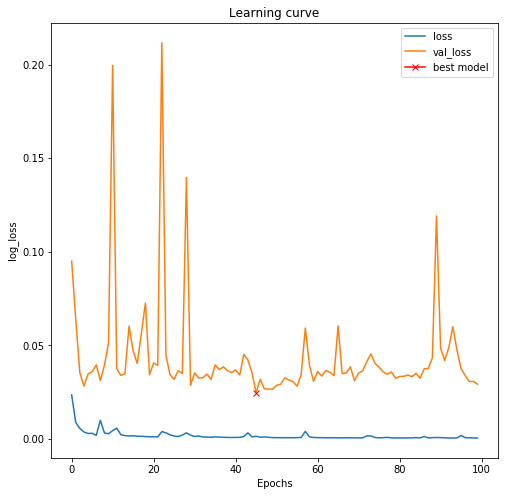

In [7]:
plot_loss_curve(results)

In [6]:
model = load_model('model_unet_disk_pretrainedRESNET34_200eqa')

Loaded model from disk


## Test and display results

In [32]:
# test_img = image_ut.normalized(cv2.imread('/home/andrea/learning/vessel_segmentation/disk/val_imgs/val/Study_02_00042_03_R_registered.avi_average_image.tif'))/255
test_img = cv2.imread('/mnt/data/aja/diplomka/disk/val_imgs/val/Study_02_00018_01_L_phase.avi_average_image.tif')/255
test_img =  cv2.resize(test_img, (512, 512))

test_mask = cv2.imread('/mnt/data/aja/diplomka/disk/val_masks/val/Study_02_00018_01_L_phase.avi_average_image.tif', cv2.IMREAD_GRAYSCALE)/255
test_mask = cv2.resize(test_mask, (512, 512))

In [ ]:
# plt.imshow(test_img)

In [33]:
test = np.expand_dims(test_img, axis=0)
preds = model.predict(preprocess_input(test))

In [34]:
prediction = np.squeeze(preds)
prediction.shape

(512, 512)

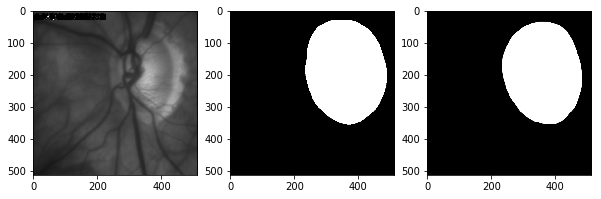

In [35]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(test_img)
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')